%%latex
\setcounter{page}{87}
\tableofcontents 
\setcounter{section}{0}

# Abstract
Experimental data from simultaneous work function and resistance measurements will be compared with the results from the numerical calculations. Results from an $SnO_2$ gas sensor measured at 300°C will be used to demonstrate, how numerical data can be used to gain more insights about the measured material.

# Fitting experimental data to numerical results
## Importing experimental and numerical data

In [313]:
#Setting up the env.
from part2 import *
import pandas as pd
%pylab inline

pd.set_option('display.max_columns', 3)
pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', 25)

#importing the data
calc_dF = pd.read_hdf('numerical_sol.h5','raw')
dF_1000 = pd.read_excel('Kelvin_Data.xlsx', sheet_name='ipc1000').sort_values(by='dV')

#instead of unsing the row number
#each row has the value of dV as index
dF_1000.index = dF_1000['dV']

Populating the interactive namespace from numpy and matplotlib


## Representing the raw data

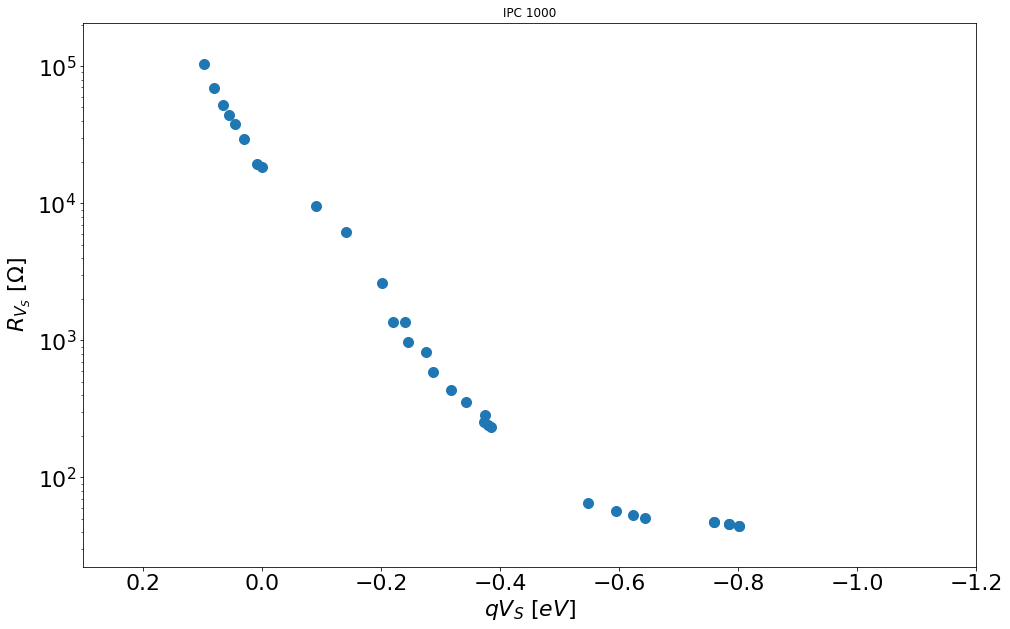

In [316]:
def format_axe(axe, ylabel = None, set_ylim=False, ):
    labelsize = 22
    if set_ylim:
        axe.set_ylim((1e-4,1e3))
    axe.set_yscale('log')
    axe.set_xlim((0.3,-1.2))
    if ylabel:
        axe.set_ylabel(ylabel, fontsize = labelsize)
    else:
        axe.set_ylabel(r'$\frac{R_{V_S}}{R_{(V_S=0)}}$', fontsize = labelsize)
    axe.set_xlabel('$qV_S$ $[eV]$', fontsize = labelsize)
    axe.tick_params(axis='both', which='both', labelsize=labelsize)

    
fig, axe = subplots(figsize=(16,10))

sens, dF = 'IPC 1000',dF_1000

v_exp = dF['dV']
res_exp = dF['res']
axe.set_title(sens)
axe.scatter(v_exp,res_exp, s=100)
format_axe(axe,ylabel='$R_{V_S}$ [$\Omega$]')
axe.set_ylim(res_exp.min()/2,res_exp.max()*2);

## From $R_{V_S}$ to $\\Delta R_{V_S} $
In the experimental dataset the value at 0$qV_s$ represent the data points measured under nitrogen. Therefore $\Delta R_{V_S} =\frac{R_{V_S}}{R_{0}}$ is calculated by :

- First derive the resistance under nitrogen R_{0}
- Second devide all resitance values by this value



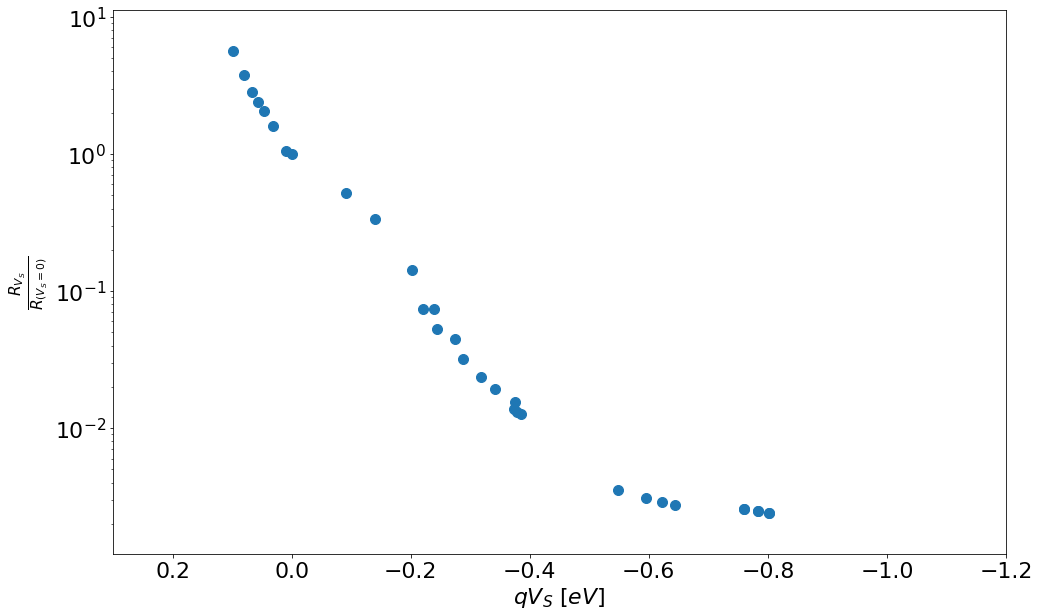

In [318]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


fig, axe = subplots(1, figsize=(16,10))

#get the value of the flatband (if needed)
#by interpolation 
interp_res = interp1d(v_exp,res_exp)
res_flatband = interp_res(0)

#calcualte the rel. res change
rel_res_exp = dF['res']/res_flatband


#represent it
format_axe(axe)
axe.scatter(dF['dV'],y, s=100)
axe.set_ylim(rel_res_exp.min()/2,
             rel_res_exp.max()*2);

## Interpolating the numerical values
In the previous section, the numerical solution for multiple start parameters have been calculated. Nevertheless most probably the calculated dataset will not hold exactly the same values gathered from the experiment. To find the best fitting numerical solution, we will need to calculate $\Delta R_{{V_S}_{,Experiment}}$ for the experimental value of ${V_S}_{,Experiment}$. Here again, a interpolation between of the existing values will do the job.
The value of $\Delta R_{{V_S}_{,Experiment}}$ will be calculated for all the experimental points and all the numerical solutions. Once this is done, the different between the numerical model and the exp. data can be calculated and evaluated.

In [321]:
#The dataframe to hold the different
#of the exp. values to the numerical ones
#Will be used to find the best fitting num. solution
num_data_at_exp_pos_dF = pd.DataFrame(index = v_exp)

#group the num. data by its paramters (T, R and ND)
data_by_grain = calc_dF.groupby(['temp','R','ND'])

for (T, R,ND), calc_dF_grain in data_by_grain:
    
    num_data_at_exp_pos_dF[(T, R,ND)] = None
    
    grain = create_grain_from_data(calc_dF_grainsize)
    
    flat_band_data = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]
        
    rel_res_num = calc_dF_grain['rel_res_change']
    
    #express the surace potential in eV
    #to be comparable with the exp. data
    v_num = calc_dF_grain['Einit_kT']*CONST.J_to_eV(grain.material.kT)
    
    #use interpolation to get the values for the positions
    #of the experiment data points
    interp_rs_num = interp1d(v_num, rel_res_num)
    interp_v_num = interp1d(rel_res_num,v_num)

    #caculate the numerical value of rel. res at the position
    # of V from the experiment
    res_num_at_exp_pos = interp_rs_num(v_exp)

    #save those values in the new DataFrame
    num_data_at_exp_pos_dF.loc[:,(T, R,ND)] = res_num_at_exp_pos


## Calculating the fit error
In `num_data_at_exp_pos_dF` the values of $\Delta R_{{V_S}_{,Experiment}}$ at the positions of ${V_S}_{,Experiment}$ are saved. From these values now the relative error needs to be calculated. The following formula is used to derive the error:

\begin{align}
\epsilon_{V_S} = \left(\frac {R_{numerical, {V_S}_{,Experiment}}-R_{experiment, {V_S}_{,Experiment}}} {R_{experiment, {V_S}_{,Experiment}}}\right)^2
\end{align}

The sum of all $\epsilon_{V_S}$ is the total error of the fit. The numerical model with the lowest value of $\sum \epsilon_{V_S}$ is the model which fits best to the experimental data.
The average grain diameter of the material "IPC100" is known to be in average 110nm <cite cite-data="Dieguez1999">(Nanoparticle engineering for gas sensor optimization: Improved sol-gel fabricated nanocrystalline SnO2 thick film gas sensor for NO2 detection by calcination, catalytic metal introduction and grinding treatments, 1999)</cite>. The dataset we created in the previous section includes models for grains with radii of 50nm and 100nm. Therefore we can narrow the fit algorithm down, to take only models with a radius of 50nm and 100nm in account

In [336]:
abs_error = num_data_at_exp_pos_dF.subtract(rel_res_exp, axis='index')
rel_error = abs_error.divide(rel_res_exp, axis='index')
rel_error_square = rel_error**2
sum_of_squares = rel_error_square.sum()

valid_index = [i for i in s.index if i[1] in [50e-9,100e-9]]

sum_of_squares_grainsize = sum_of_squares.loc[valid_index].sort_values()

grain_min_error_tuple = sum_of_squares_grainsize.idxmin()
display(pd.DataFrame({'error':sum_of_squares_grainsize}))
grain_min_error_tuple

,error
"(300.0, 5e-08, 1e+22)",6.82
"(300.0, 1e-07, 1e+22)",7.67
"(300.0, 1e-07, 1e+21)",14.36
"(300.0, 5e-08, 1e+21)",18.77
"(300.0, 5e-08, 1e+23)",175.20
"(300.0, 1e-07, 1e+23)",1256.74
"(300.0, 5e-08, 1e+24)",9905.88
"(300.0, 1e-07, 1e+24)",39709.78


(300.0, 5e-08, 1e+22)

## Representation of the fit
Finally the best to fir results are represented graphically.


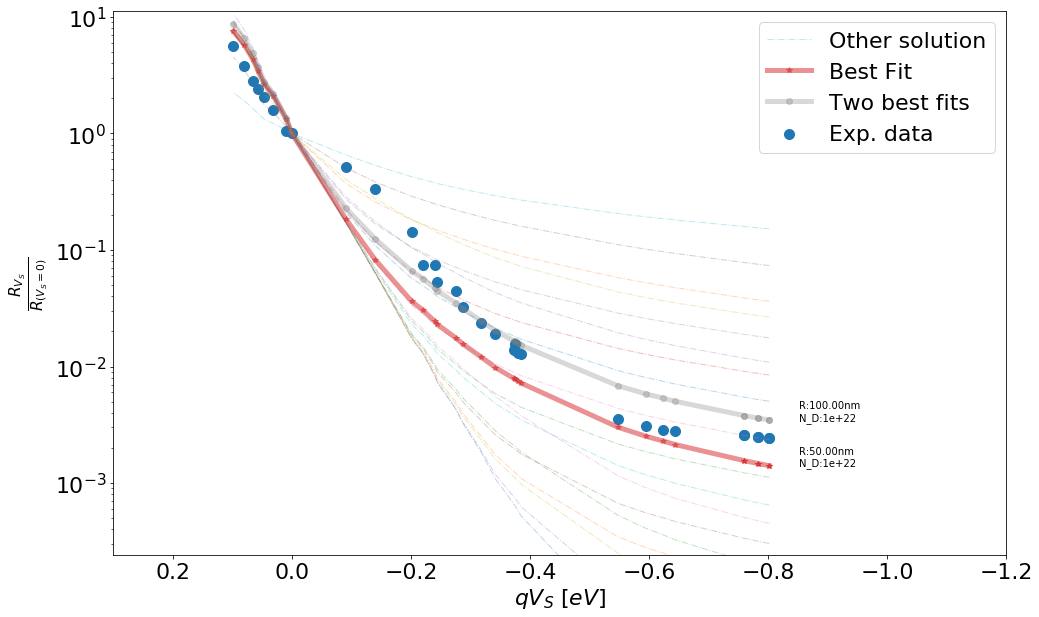

In [339]:
fig, axe = subplots(figsize = (16,10))
#for grain_tuple in num_data_at_exp_pos_dF.keys():
for grain_tuple in sum_of_squares.index:   
    if grain_tuple == grain_min_error_tuple:
        linestyle = '*-'
        linewidth = 5
        alpha = 0.5
        label = 'Best Fit'
    elif grain_tuple in sum_of_squares_grainsize.index[0:2]:
        linestyle = '-o'
        linewidth = 5
        alpha = 0.3
        label = 'Two best fits'
    else:
        linestyle = '-.'
        linewidth = 1
        alpha = 0.3
        label = 'Other solution'

        

        
    axe.plot(num_data_at_exp_pos_dF.index,
                num_data_at_exp_pos_dF[grain_tuple],
            linestyle, linewidth=linewidth, alpha = alpha,
            label =label)
    

    last_x  = num_data_at_exp_pos_dF.index[0] 
    last_y  = num_data_at_exp_pos_dF.iloc[0][grain_tuple]
    
    if grain_tuple in sum_of_squares_grainsize.index[0:2]:
        axe.text(last_x-0.05,last_y,
                 f'''R:{grain_tuple[1]*1e9:.2f}nm\nN_D:{grain_tuple[2]:.2}'''                )
format_axe(axe)

axe.scatter(rel_res_exp.index,
            rel_res_exp,
            s=100,
            label = 'Exp. data'
           )

axe.set_ylim(rel_res_exp.min()/10,
             rel_res_exp.max()*2);


l = {h[1]:h[0] for h in zip(*axe.get_legend_handles_labels())}.keys()
h = {h[1]:h[0] for h in zip(*axe.get_legend_handles_labels())}.values()
axe.legend(h,l,loc=1, fontsize = 22)

(10000.0, 1000000.0)

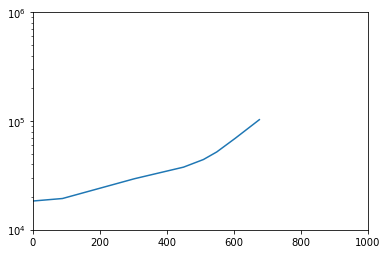

In [360]:

best_dF = data_by_grain.get_group(grain_min_error_tuple)
grain = create_grain_from_data(best_dF)

rel_res_num = calc_dF_grain['rel_res_change']
v_num = best_dF['Einit_kT']*CONST.J_to_eV(grain.material.kT)

interp_charge = interp1d(v_num, best_dF['charges_trapped_at_surface']/best_dF['grain_vol'])

sc = interp_charge(v_exp)
sc = sc/2.5e25*1e6
fig, axe = subplots()

axe.plot(sc, res_exp)
axe.set_yscale('log')
#axe.set_xscale('log')
axe.set_xlim(0,1000)
axe.set_ylim(1e4,1e6)

# Conclusion
We can see, that both fits no not fit perfectly to the experimental data. One reason might be, that the screening of the parameters was to curse. A second iteration of creating models with radii between 50nm and 100nm might find a better fit. Also a fine screening of $N_D$ will turn out to be helpful for a better result.
On the other side the fitting shows, that the data can be described by a model of a 50nm grain with a defect concentration of $N_D=1*10^{22}$ at 300°C.

# Bibliography section

%%latex
\bibliographystyle{alphadin}
\bibliography{ipython}